### Цели и задачи проекта
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Определиться с параметрами модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы, провести разведывательный анализ данных и составить отчёт по результатам. 

In [ ]:
# Importing Libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [87]:
# Set options for data preview
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

### 1. Первичный отсмотр данных

In [88]:
# Reading the Data
dataset = pd.read_csv('stud_math.csv')

# Rename columns
original_cols = dataset.columns
new_cols = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
            'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime_granular', 'higher',
            'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']
dataset = dataset.rename(columns=dict(zip(original_cols, new_cols)))

In [89]:
dataset.info()  # get some info about dataset
dataset.sample(10)  #see how many null values in out dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
321,GP,F,17,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,no,yes,4.0,2.0,2.0,3.0,12.0,45.0
354,MS,M,17,NaN,GT3,T,4.0,3.0,services,other,home,mother,2.0,2.0,0.0,no,yes,yes,yes,no,-6.0,yes,yes,yes,4.0,5.0,5.0,2.0,4.0,55.0
207,GP,F,16,U,GT3,T,4.0,3.0,teacher,other,other,mother,1.0,2.0,0.0,no,no,yes,NaN,yes,-6.0,yes,yes,yes,1.0,3.0,2.0,1.0,10.0,65.0
179,GP,M,17,U,GT3,T,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,2.0,3.0,2.0,4.0,55.0
290,GP,M,18,U,GT3,T,4.0,NaN,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,NaN,2.0,5.0,11.0,55.0
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0
258,GP,M,18,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,2.0,0.0,no,no,no,yes,yes,-6.0,yes,NaN,no,5.0,2.0,4.0,4.0,8.0,70.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
124,GP,F,16,U,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,yes,no,yes,-6.0,yes,yes,yes,5.0,4.0,4.0,5.0,0.0,40.0
62,GP,F,16,U,LE3,T,1.0,2.0,other,services,reputation,father,1.0,2.0,0.0,yes,no,no,yes,yes,-6.0,yes,yes,no,4.0,4.0,3.0,1.0,4.0,45.0


### 2. Функции для анализа и очистки данных 

##### Primary Data Analysis and NULL processing 

In [90]:
# Get object data type column info
def get_object_column_info(column):
    display(pd.DataFrame(dataset[column].value_counts()))
    get_boxplot(column)
    get_null_values_percent(column)


# Get float data type column info
def get_float_column_info(column):
    display(dataset[column].describe())
    dataset[column].hist(legend=True)
    plt.show()
    get_null_values_percent(column)


# Get percent of null values in column
def get_null_values_percent(column):
    nanPercent = len(dataset[dataset[column].isnull()])/len(dataset)
    print('Percent nullable records in \033[1m{}\033[0m column: {:2.1%}'.format(
        column, nanPercent))
    return nanPercent


# Get box plot
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=dataset.loc[dataset.loc[:, column].isin(
                    dataset.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Run primary data analysis for column
def run_primary_data_analysis(col):
    print('\033[1mCOLUMN: {} \033[0m'.format(col.upper()))
    if dataset.dtypes[col].name == 'object':
        get_object_column_info(col)
    else:
        get_float_column_info(col)
    print('----------------------------------------------')
    print()


# Replace null values in column
def replace_null_values(column):
    # Заменяем отсутствующие значения номинативной переменной в соотношении существующих значений
    mask = dataset[column].isna()
    # считаем статистику распределения значений
    p = dataset[column].value_counts() / len(dataset[column].dropna())
    # заполняем пропуски с вероятностью 'p'
    dataset.loc[mask, column] = np.random.choice(
        p.index.to_list(), size=mask.sum(), p=p.to_list())


# Process primary data
def process_primary_data(replaceNa=False):
    for col in dataset.columns:
        if replaceNa == True:
            nanPercent = get_null_values_percent(col)
            if nanPercent > 0:
                replace_null_values(col)
                print(
                    '\033[1mReplace NULL in {} column is completed.\033[0m'.format(col))
        else:
            run_primary_data_analysis(col)

##### Outliers Analysis and processing 

In [91]:
# Process outliers
def process_outliers(cleanup=False):
    global dataset
    numericColumns = [col for col in list(
        dataset.columns) if dataset.dtypes[col].name != 'object']
    for col in numericColumns:
        outlierCount, ds = get_outlier(col, cleanup)
        if cleanup == True and outlierCount > 0:
            dataset = ds
            print('\033[1mCOLUMN: {} \033[0m ВЫБРОСЫ: Удалено {} записей. Осталось {} записей.'.format(
                col.upper(), outlierCount, len(dataset)))


# Get outliers
def get_outlier(column, cleanup = False):
    IQR = dataset[column].quantile(0.75) - dataset[column].quantile(0.25)
    perc25 = dataset[column].quantile(0.25)
    perc75 = dataset[column].quantile(0.75)

    ds = dataset.loc[dataset[column].between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    outlierCount = len(dataset) - len(ds)
    if cleanup == False:
        #dataset[column].hist(legend=True)
        
        print('\033[1mCOLUMN: {} \033[0m'.format(column.upper()))
        print('25-й перцентиль: {}.'.format(perc25))
        print('75-й перцентиль: {}.'.format(perc75))
        print('IQR: {}.'.format(IQR))
        print('Границы выбросов: [{f}, {l}].'.format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
        print('\033[1mКоличесто выбросов: {}.\033[0m'.format(outlierCount))

        dataset[column].loc[dataset[column].between(
            perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(0, 10), label='IQR')
        plt.legend()
        plt.show()
        
    return (outlierCount, ds)

##### Statistic Functions 

In [92]:
# Get statistic differences
def get_stat_dif(column):
    cols = dataset.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(dataset.loc[dataset.loc[:, column] == comb[0], 'score'],
                     dataset.loc[dataset.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

### 3. Первичный анализ данных в столбцах

COLUMN: SCHOOL 


,school
GP,241
MS,34


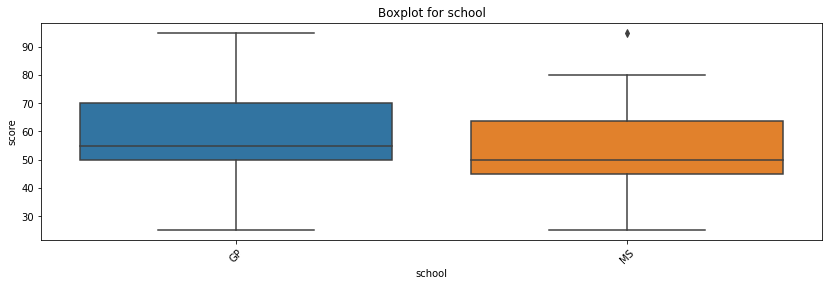

Percent nullable records in school column: 0.0%
----------------------------------------------

COLUMN: SEX 


,sex
F,138
M,137


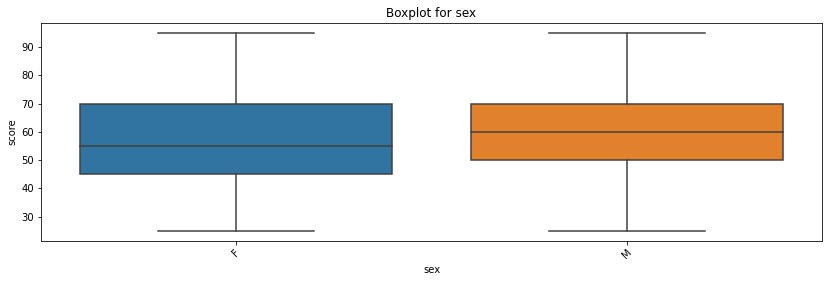

Percent nullable records in sex column: 0.0%
----------------------------------------------

COLUMN: AGE 


count    275.000000
mean      16.654545
std        1.238350
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

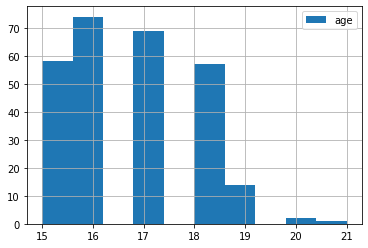

Percent nullable records in age column: 0.0%
----------------------------------------------

COLUMN: ADDRESS 


,address
U,216
R,59


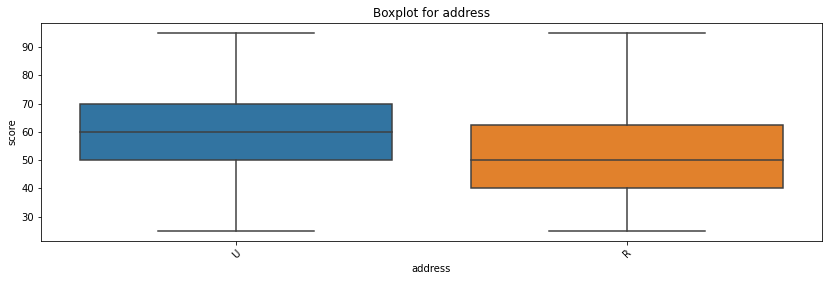

Percent nullable records in address column: 0.0%
----------------------------------------------

COLUMN: FAMSIZE 


,famsize
GT3,198
LE3,77


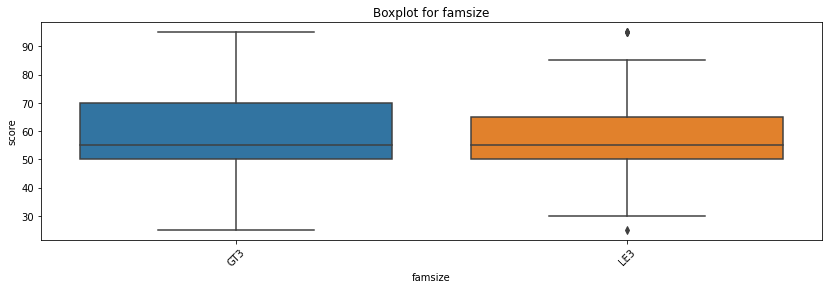

Percent nullable records in famsize column: 0.0%
----------------------------------------------

COLUMN: PSTATUS 


,pstatus
T,248
A,27


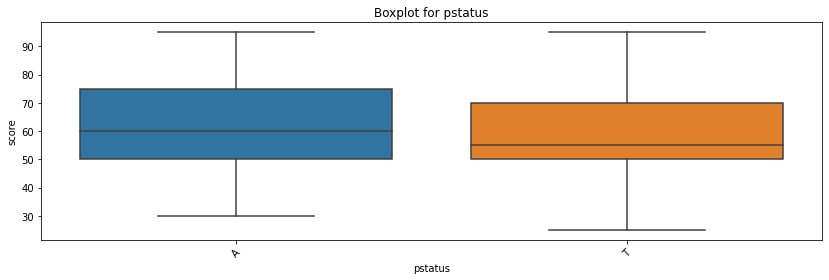

Percent nullable records in pstatus column: 0.0%
----------------------------------------------

COLUMN: MEDU 


count    275.000000
mean       2.763636
std        1.116624
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

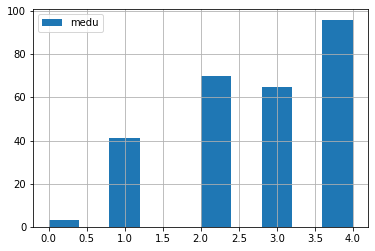

Percent nullable records in medu column: 0.0%
----------------------------------------------

COLUMN: FEDU 


count    275.000000
mean       2.560000
std        1.066682
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

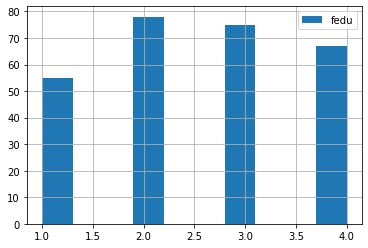

Percent nullable records in fedu column: 0.0%
----------------------------------------------

COLUMN: MJOB 


,mjob
other,97
services,68
teacher,44
at_home,43
health,23


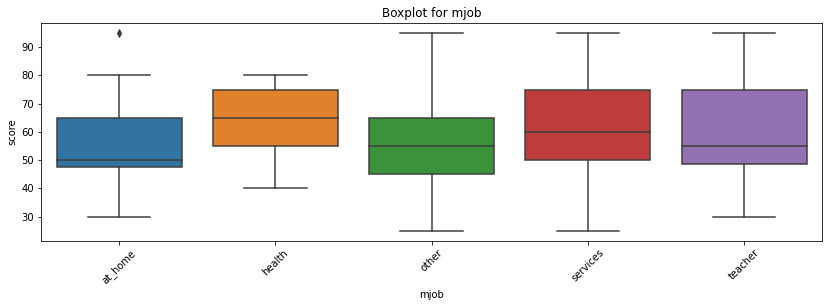

Percent nullable records in mjob column: 0.0%
----------------------------------------------

COLUMN: FJOB 


,fjob
other,152
services,77
teacher,21
at_home,14
health,11


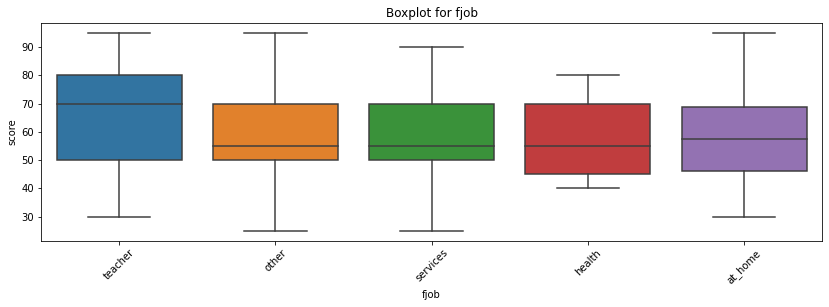

Percent nullable records in fjob column: 0.0%
----------------------------------------------

COLUMN: REASON 


,reason
course,104
home,74
reputation,69
other,28


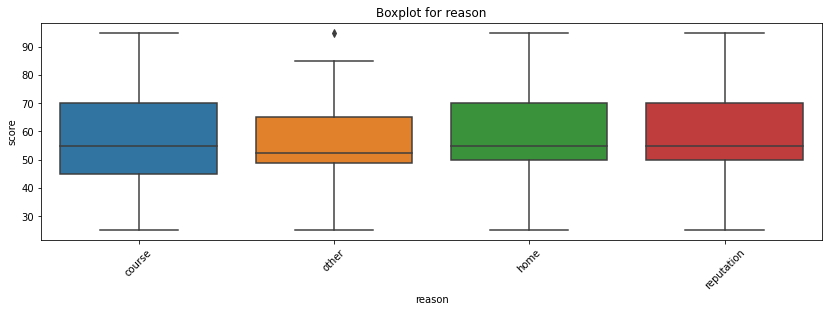

Percent nullable records in reason column: 0.0%
----------------------------------------------

COLUMN: GUARDIAN 


,guardian
mother,189
father,63
other,23


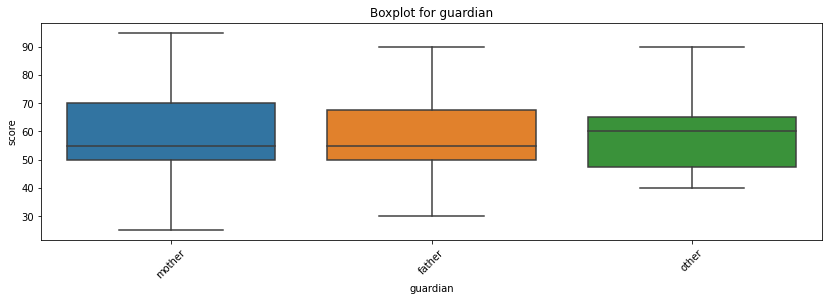

Percent nullable records in guardian column: 0.0%
----------------------------------------------

COLUMN: TRAVELTIME 


count    275.000000
mean       1.381818
std        0.594712
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: traveltime, dtype: float64

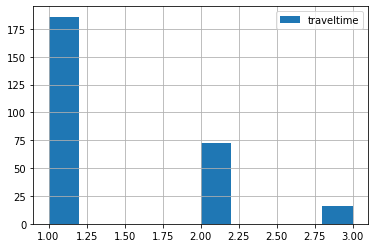

Percent nullable records in traveltime column: 0.0%
----------------------------------------------

COLUMN: STUDYTIME 


count    275.000000
mean       1.930909
std        0.671873
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: studytime, dtype: float64

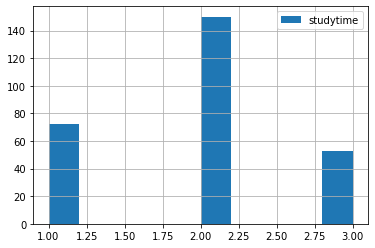

Percent nullable records in studytime column: 0.0%
----------------------------------------------

COLUMN: SCHOOLSUP 


,schoolsup
no,239
yes,36


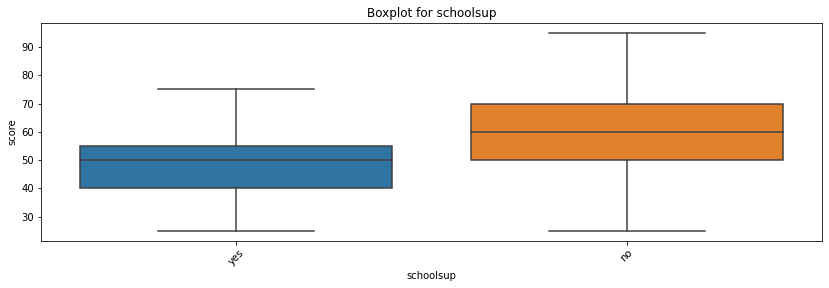

Percent nullable records in schoolsup column: 0.0%
----------------------------------------------

COLUMN: FAMSUP 


,famsup
yes,166
no,109


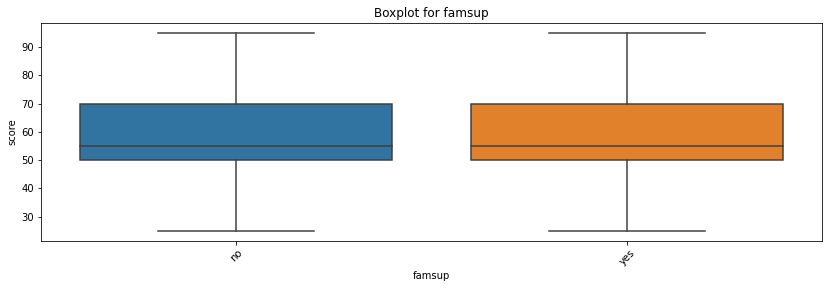

Percent nullable records in famsup column: 0.0%
----------------------------------------------

COLUMN: PAID 


,paid
no,151
yes,124


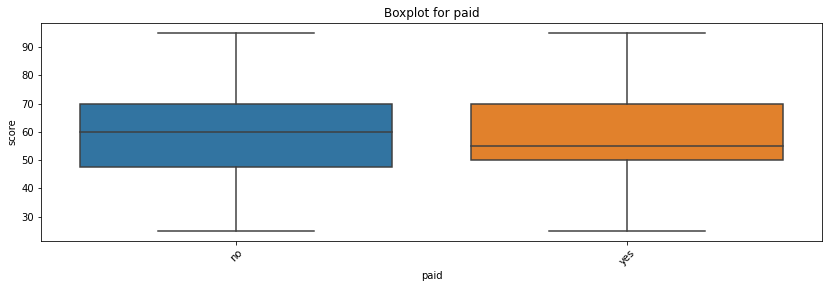

Percent nullable records in paid column: 0.0%
----------------------------------------------

COLUMN: ACTIVITIES 


,activities
yes,142
no,133


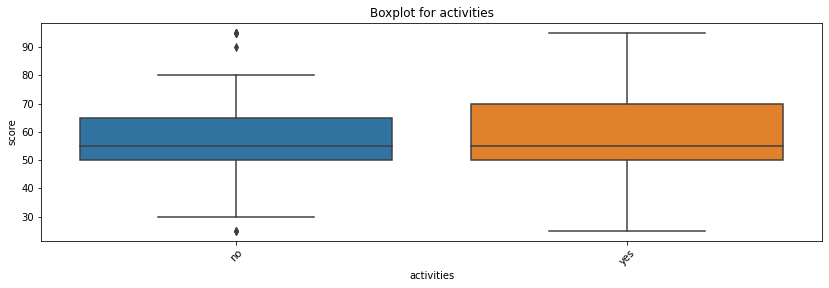

Percent nullable records in activities column: 0.0%
----------------------------------------------

COLUMN: NURSERY 


,nursery
yes,215
no,60


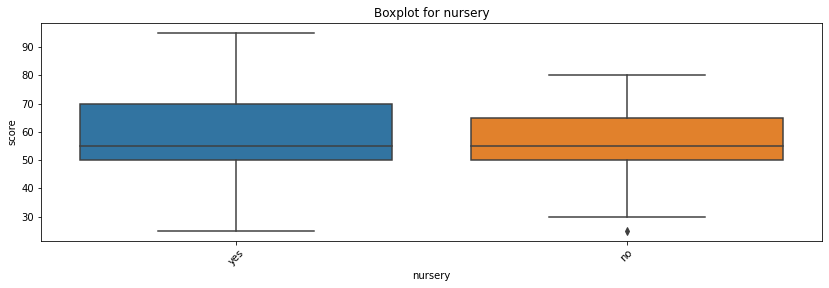

Percent nullable records in nursery column: 0.0%
----------------------------------------------

COLUMN: HIGHER 


,higher
yes,263
no,12


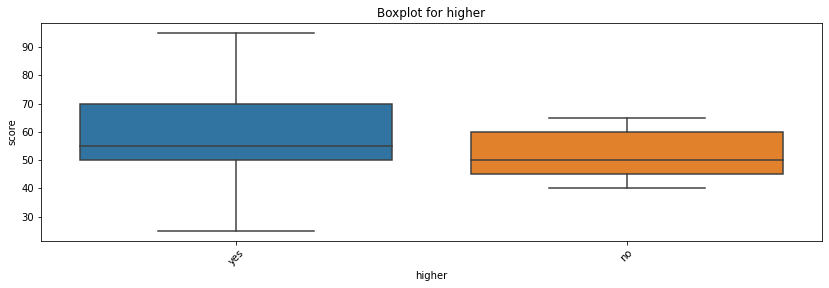

Percent nullable records in higher column: 0.0%
----------------------------------------------

COLUMN: INTERNET 


,internet
yes,235
no,40


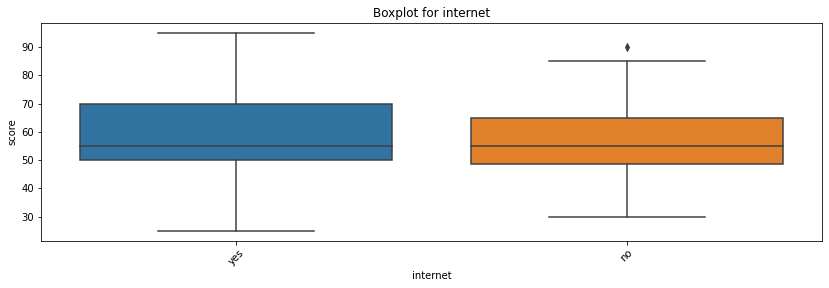

Percent nullable records in internet column: 0.0%
----------------------------------------------

COLUMN: ROMANTIC 


,romantic
no,187
yes,88


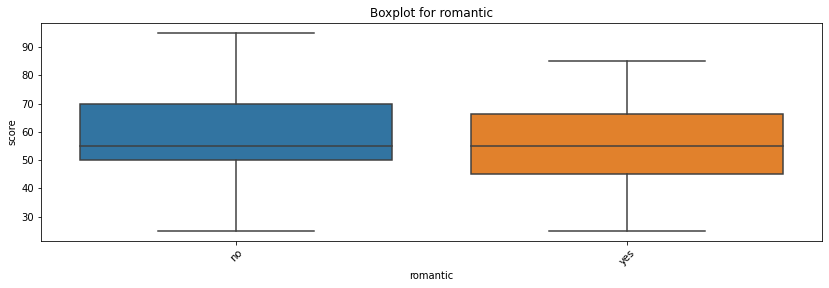

Percent nullable records in romantic column: 0.0%
----------------------------------------------

COLUMN: FAMREL 


count    275.000000
mean       4.120000
std        0.670113
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

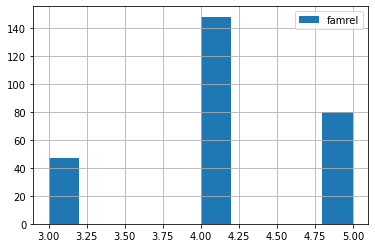

Percent nullable records in famrel column: 0.0%
----------------------------------------------

COLUMN: FREETIME 


count    275.000000
mean       3.367273
std        0.891782
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

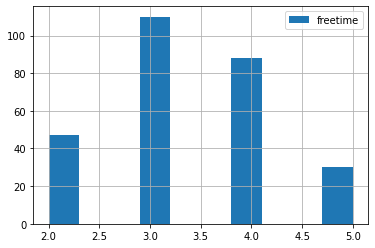

Percent nullable records in freetime column: 0.0%
----------------------------------------------

COLUMN: GOOUT 


count    275.000000
mean       3.083636
std        1.075738
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

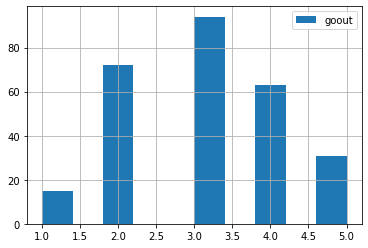

Percent nullable records in goout column: 0.0%
----------------------------------------------

COLUMN: HEALTH 


count    275.000000
mean       3.607273
std        1.366419
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

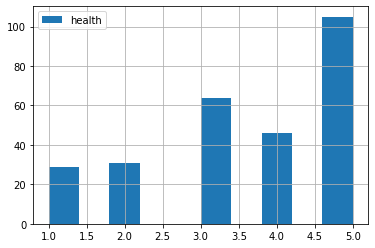

Percent nullable records in health column: 0.0%
----------------------------------------------

COLUMN: ABSENCES 


count    275.000000
mean       5.014545
std        5.116148
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       20.000000
Name: absences, dtype: float64

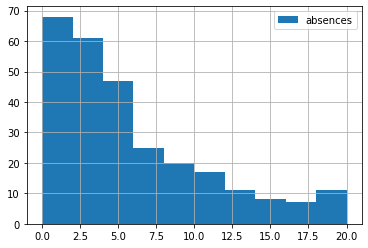

Percent nullable records in absences column: 0.0%
----------------------------------------------

COLUMN: SCORE 


count    275.000000
mean      58.145455
std       15.725077
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

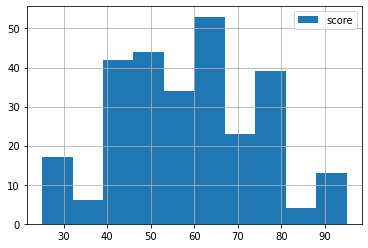

Percent nullable records in score column: 0.0%
----------------------------------------------



In [103]:
process_primary_data()  # Primary data analysis

### 4. Обработка пропусков и выбросов

In [95]:
dataset.drop(['studytime_granular'], inplace = True, axis = 1)  # Удаляем по причине что значения коррелируют с studytime
dataset.drop(['failures'], inplace = True, axis = 1)  # Удаляем по причине что все значения кроме 0 являются выбросами

# Удаляем колонки у которых более чем 10% null значения
for col in dataset.columns:
     if get_null_values_percent(col) > 10:
        dataset.drop([col], inplace = True, axis = 1)


Percent nullable records in school column: 0.0%
Percent nullable records in sex column: 0.0%
Percent nullable records in age column: 0.0%
Percent nullable records in address column: 4.3%
Percent nullable records in famsize column: 6.8%
Percent nullable records in pstatus column: 11.4%
Percent nullable records in medu column: 0.8%
Percent nullable records in fedu column: 6.1%
Percent nullable records in mjob column: 4.8%
Percent nullable records in fjob column: 9.1%
Percent nullable records in reason column: 4.3%
Percent nullable records in guardian column: 7.8%
Percent nullable records in traveltime column: 7.1%
Percent nullable records in studytime column: 1.8%
Percent nullable records in schoolsup column: 2.3%
Percent nullable records in famsup column: 9.9%
Percent nullable records in paid column: 10.1%
Percent nullable records in activities column: 3.5%
Percent nullable records in nursery column: 4.1%
Percent nullable records in higher column: 5.1%
Percent nullable records in intern

Percent nullable records in school column: 0.0%
Percent nullable records in sex column: 0.0%
Percent nullable records in age column: 0.0%
Percent nullable records in address column: 4.3%
Replace NULL in address column is completed.
Percent nullable records in famsize column: 6.8%
Replace NULL in famsize column is completed.
Percent nullable records in pstatus column: 11.4%
Replace NULL in pstatus column is completed.
Percent nullable records in medu column: 0.8%
Replace NULL in medu column is completed.
Percent nullable records in fedu column: 6.1%
Replace NULL in fedu column is completed.
Percent nullable records in mjob column: 4.8%
Replace NULL in mjob column is completed.
Percent nullable records in fjob column: 9.1%
Replace NULL in fjob column is completed.
Percent nullable records in reason column: 4.3%
Replace NULL in reason column is completed.
Percent nullable records in guardian column: 7.8%
Replace NULL in guardian column is completed.
Percent nullable records in traveltime 

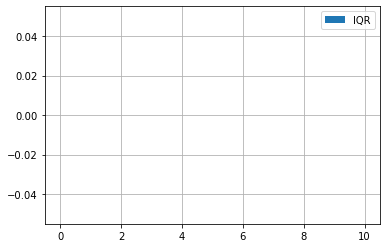

COLUMN: MEDU 
25-й перцентиль: 2.0.
75-й перцентиль: 4.0.
IQR: 2.0.
Границы выбросов: [-1.0, 7.0].
Количесто выбросов: 0.


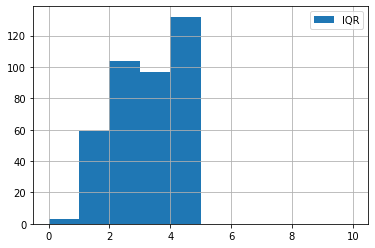

COLUMN: FEDU 
25-й перцентиль: 2.0.
75-й перцентиль: 3.0.
IQR: 1.0.
Границы выбросов: [0.5, 4.5].
Количесто выбросов: 4.


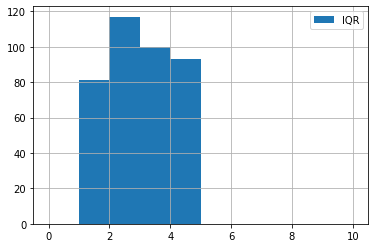

COLUMN: TRAVELTIME 
25-й перцентиль: 1.0.
75-й перцентиль: 2.0.
IQR: 1.0.
Границы выбросов: [-0.5, 3.5].
Количесто выбросов: 8.


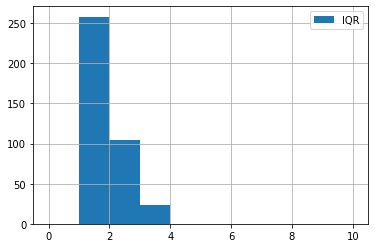

COLUMN: STUDYTIME 
25-й перцентиль: 1.0.
75-й перцентиль: 2.0.
IQR: 1.0.
Границы выбросов: [-0.5, 3.5].
Количесто выбросов: 27.


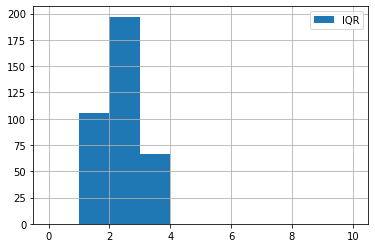

COLUMN: FAMREL 
25-й перцентиль: 4.0.
75-й перцентиль: 5.0.
IQR: 1.0.
Границы выбросов: [2.5, 6.5].
Количесто выбросов: 30.


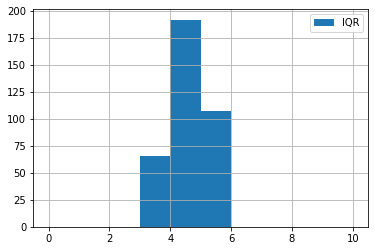

COLUMN: FREETIME 
25-й перцентиль: 3.0.
75-й перцентиль: 4.0.
IQR: 1.0.
Границы выбросов: [1.5, 5.5].
Количесто выбросов: 18.


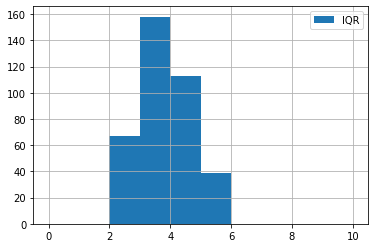

COLUMN: GOOUT 
25-й перцентиль: 2.0.
75-й перцентиль: 4.0.
IQR: 2.0.
Границы выбросов: [-1.0, 7.0].
Количесто выбросов: 0.


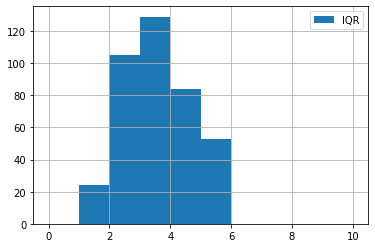

COLUMN: HEALTH 
25-й перцентиль: 3.0.
75-й перцентиль: 5.0.
IQR: 2.0.
Границы выбросов: [0.0, 8.0].
Количесто выбросов: 0.


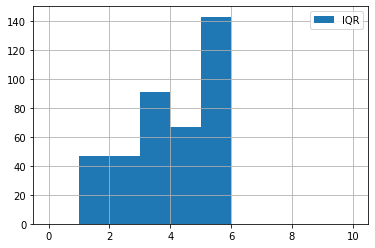

COLUMN: ABSENCES 
25-й перцентиль: 0.0.
75-й перцентиль: 8.0.
IQR: 8.0.
Границы выбросов: [-12.0, 20.0].
Количесто выбросов: 17.


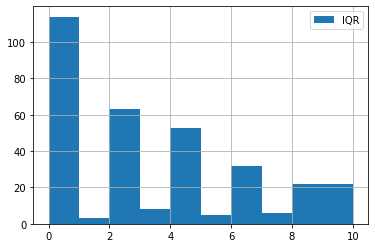

COLUMN: SCORE 
25-й перцентиль: 40.0.
75-й перцентиль: 70.0.
IQR: 30.0.
Границы выбросов: [-5.0, 115.0].
Количесто выбросов: 0.


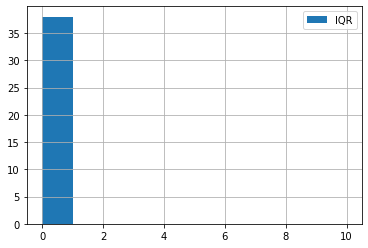

In [96]:
process_primary_data(replaceNa=True)  # Replace null values
process_outliers()  # Run outlier search

In [97]:
process_outliers(cleanup=True)  # Do outliers cleanup

COLUMN: AGE  ВЫБРОСЫ: Удалено 1 записей. Осталось 394 записей.
COLUMN: FEDU  ВЫБРОСЫ: Удалено 4 записей. Осталось 390 записей.
COLUMN: TRAVELTIME  ВЫБРОСЫ: Удалено 8 записей. Осталось 382 записей.
COLUMN: STUDYTIME  ВЫБРОСЫ: Удалено 25 записей. Осталось 357 записей.
COLUMN: FAMREL  ВЫБРОСЫ: Удалено 27 записей. Осталось 330 записей.
COLUMN: FREETIME  ВЫБРОСЫ: Удалено 12 записей. Осталось 318 записей.
COLUMN: ABSENCES  ВЫБРОСЫ: Удалено 13 записей. Осталось 305 записей.
COLUMN: SCORE  ВЫБРОСЫ: Удалено 30 записей. Осталось 275 записей.


### 5. Визуализация распределения для количественных переменных 

COLUMN: AGE 


count    275.000000
mean      16.654545
std        1.238350
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

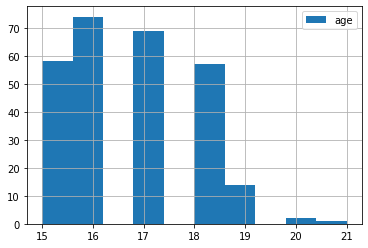

Percent nullable records in age column: 0.0%
----------------------------------------------

COLUMN: AGE 
25-й перцентиль: 16.0.
75-й перцентиль: 18.0.
IQR: 2.0.
Границы выбросов: [13.0, 21.0].
Количесто выбросов: 0.


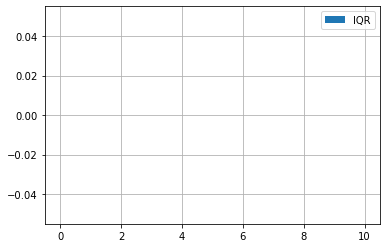

COLUMN: MEDU 


count    275.000000
mean       2.763636
std        1.116624
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

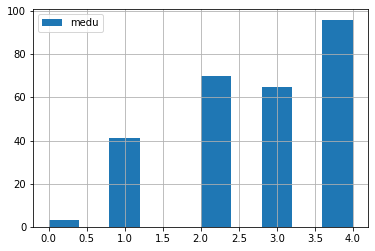

Percent nullable records in medu column: 0.0%
----------------------------------------------

COLUMN: MEDU 
25-й перцентиль: 2.0.
75-й перцентиль: 4.0.
IQR: 2.0.
Границы выбросов: [-1.0, 7.0].
Количесто выбросов: 0.


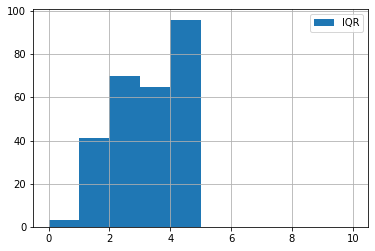

COLUMN: FEDU 


count    275.000000
mean       2.560000
std        1.066682
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

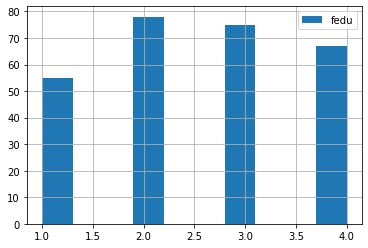

Percent nullable records in fedu column: 0.0%
----------------------------------------------

COLUMN: FEDU 
25-й перцентиль: 2.0.
75-й перцентиль: 3.0.
IQR: 1.0.
Границы выбросов: [0.5, 4.5].
Количесто выбросов: 0.


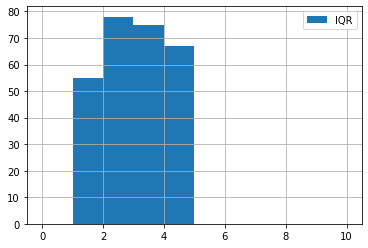

COLUMN: TRAVELTIME 


count    275.000000
mean       1.381818
std        0.594712
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: traveltime, dtype: float64

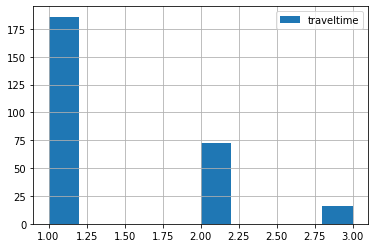

Percent nullable records in traveltime column: 0.0%
----------------------------------------------

COLUMN: TRAVELTIME 
25-й перцентиль: 1.0.
75-й перцентиль: 2.0.
IQR: 1.0.
Границы выбросов: [-0.5, 3.5].
Количесто выбросов: 0.


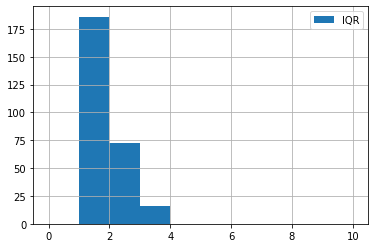

COLUMN: STUDYTIME 


count    275.000000
mean       1.930909
std        0.671873
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: studytime, dtype: float64

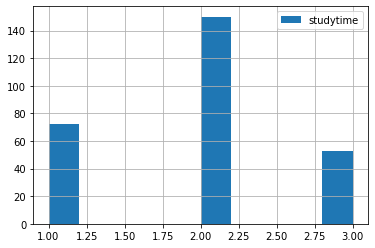

Percent nullable records in studytime column: 0.0%
----------------------------------------------

COLUMN: STUDYTIME 
25-й перцентиль: 1.0.
75-й перцентиль: 2.0.
IQR: 1.0.
Границы выбросов: [-0.5, 3.5].
Количесто выбросов: 0.


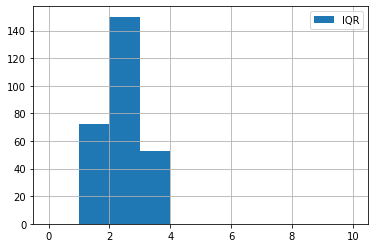

COLUMN: FAMREL 


count    275.000000
mean       4.120000
std        0.670113
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

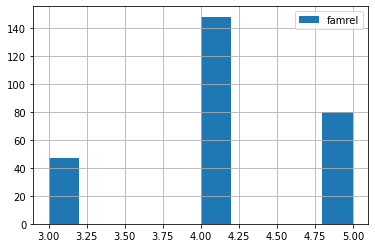

Percent nullable records in famrel column: 0.0%
----------------------------------------------

COLUMN: FAMREL 
25-й перцентиль: 4.0.
75-й перцентиль: 5.0.
IQR: 1.0.
Границы выбросов: [2.5, 6.5].
Количесто выбросов: 0.


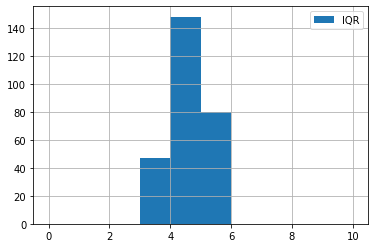

COLUMN: FREETIME 


count    275.000000
mean       3.367273
std        0.891782
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

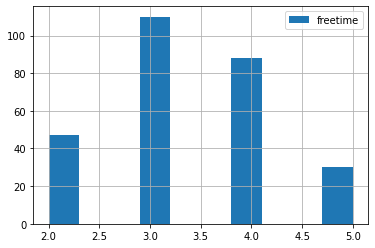

Percent nullable records in freetime column: 0.0%
----------------------------------------------

COLUMN: FREETIME 
25-й перцентиль: 3.0.
75-й перцентиль: 4.0.
IQR: 1.0.
Границы выбросов: [1.5, 5.5].
Количесто выбросов: 0.


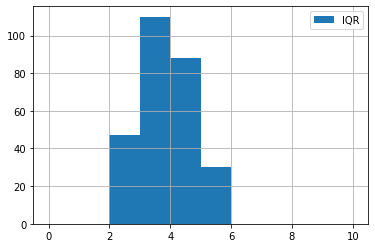

COLUMN: GOOUT 


count    275.000000
mean       3.083636
std        1.075738
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

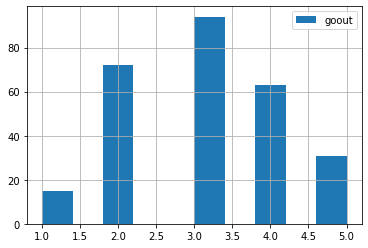

Percent nullable records in goout column: 0.0%
----------------------------------------------

COLUMN: GOOUT 
25-й перцентиль: 2.0.
75-й перцентиль: 4.0.
IQR: 2.0.
Границы выбросов: [-1.0, 7.0].
Количесто выбросов: 0.


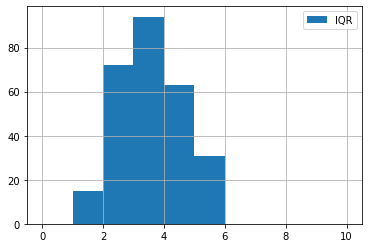

COLUMN: HEALTH 


count    275.000000
mean       3.607273
std        1.366419
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

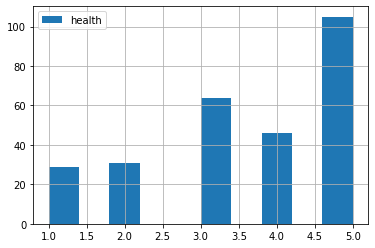

Percent nullable records in health column: 0.0%
----------------------------------------------

COLUMN: HEALTH 
25-й перцентиль: 3.0.
75-й перцентиль: 5.0.
IQR: 2.0.
Границы выбросов: [0.0, 8.0].
Количесто выбросов: 0.


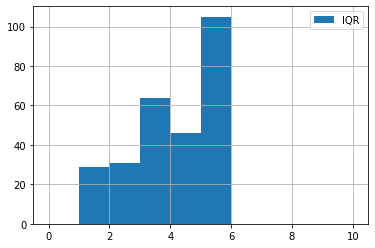

COLUMN: ABSENCES 


count    275.000000
mean       5.014545
std        5.116148
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       20.000000
Name: absences, dtype: float64

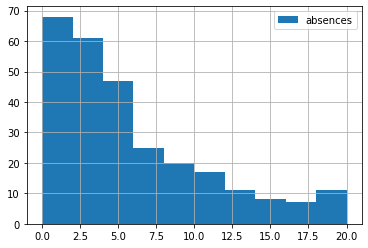

Percent nullable records in absences column: 0.0%
----------------------------------------------

COLUMN: ABSENCES 
25-й перцентиль: 2.0.
75-й перцентиль: 8.0.
IQR: 6.0.
Границы выбросов: [-7.0, 17.0].
Количесто выбросов: 11.


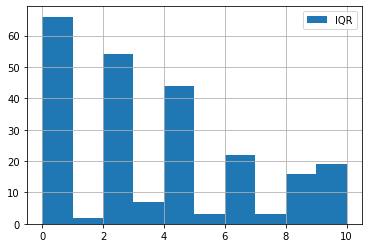

COLUMN: SCORE 


count    275.000000
mean      58.145455
std       15.725077
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

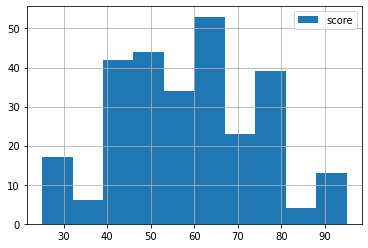

Percent nullable records in score column: 0.0%
----------------------------------------------

COLUMN: SCORE 
25-й перцентиль: 50.0.
75-й перцентиль: 70.0.
IQR: 20.0.
Границы выбросов: [20.0, 100.0].
Количесто выбросов: 0.


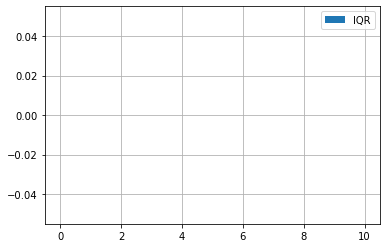

In [98]:
columns = [col for col in list(dataset.columns)
           if dataset.dtypes[col].name != 'object']
for col in columns:
    run_primary_data_analysis(col)
    get_outlier(col)

,age,medu,fedu,traveltime,studytime,famrel,freetime,goout,health,absences,score
age,1.000000,-0.180676,-0.176275,0.150021,0.089644,0.014953,0.009554,0.153273,-0.011451,0.194350,-0.133289
medu,-0.180676,1.000000,0.574219,-0.083437,0.114365,0.120961,0.021524,0.049939,-0.020397,0.001882,0.218129
fedu,-0.176275,0.574219,1.000000,-0.033368,0.049091,0.028184,-0.044352,0.019465,-0.023838,-0.036942,0.162229
traveltime,0.150021,-0.083437,-0.033368,1.000000,-0.107282,-0.032968,0.009884,-0.021574,-0.007921,-0.048612,-0.033278
studytime,0.089644,0.114365,0.049091,-0.107282,1.000000,0.091437,-0.121957,-0.002075,-0.085319,-0.114375,0.129457
famrel,0.014953,0.120961,0.028184,-0.032968,0.091437,1.000000,0.109197,0.051844,0.043685,-0.052673,0.085270
freetime,0.009554,0.021524,-0.044352,0.009884,-0.121957,0.109197,1.000000,0.169496,0.025954,0.123613,-0.011110
goout,0.153273,0.049939,0.019465,-0.021574,-0.002075,0.051844,0.169496,1.000000,0.007530,0.121131,-0.146137
health,-0.011451,-0.020397,-0.023838,-0.007921,-0.085319,0.043685,0.025954,0.007530,1.000000,0.014916,-0.067991
absences,0.194350,0.001882,-0.036942,-0.048612,-0.114375,-0.052673,0.123613,0.121131,0.014916,1.000000,-0.202668


<AxesSubplot:>

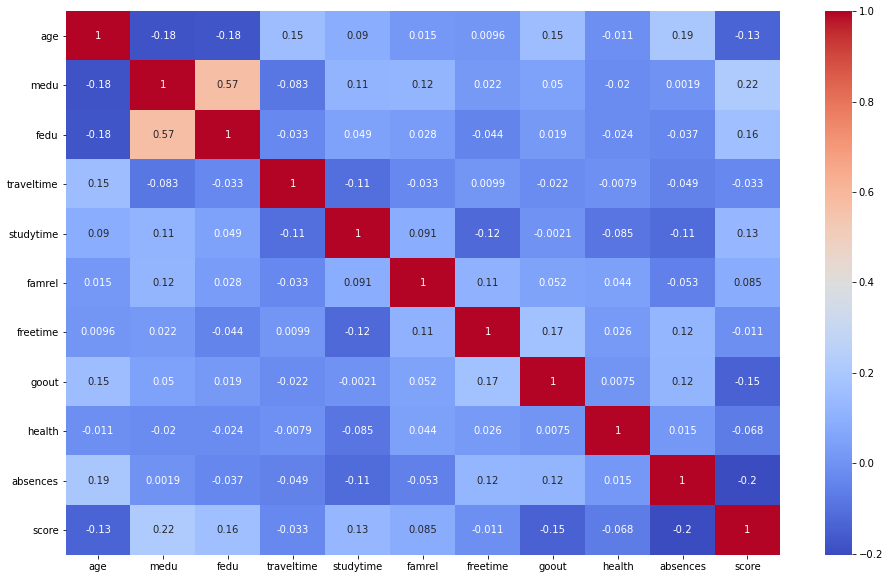

In [99]:
display(dataset.corr())
plt.figure(figsize=(16, 10))
sns.heatmap(dataset.corr(), annot = True, cmap = 'coolwarm')

### 6. Корреляционный анализ номинативных переменных

In [101]:
columns = [col for col in list(dataset.columns)
           if dataset.dtypes[col].name == 'object']
for col in columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup


### 7. Промежуточные выводы

1. В данных практически во всех колонках есть пустых значения, в 13 колонках более 5% пустые, в 2 колонках более 10% пустые.
2. Выбросы найдены в 8 столбцах из 29, что составляет приблизительно 30% выборки, что позволяет сделать вывод о том, что данные не достаточно чистые.
3. Положительная корреляция параметра studytime и score может говорить о том, что время на учёбу помимо школы положительно сказывается на баллах по госэкзамену по математике, а отрицательная кореляция freetime и score, может говорить о том, что  увеличение свободного время после школы негативно сказывается на баллах по госэкзамену по математике.
4. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это address, schoolsup, freetime, traveltime, health, famrel, studytime, age, goout. 

### 8. Итоги работы: Выбор признаков для построения модели

In [105]:
ds_for_model = dataset.loc[:, ['address', 'schoolsup', 'freetime', 'traveltime', 'health', 'famrel', 'studytime', 'age', 'goout', 'score']]
ds_for_model.head()

,address,schoolsup,freetime,traveltime,health,famrel,studytime,age,goout,score
0,U,yes,3.0,2.0,3.0,4.0,2.0,18,4.0,30.0
1,U,no,3.0,1.0,3.0,5.0,2.0,17,3.0,30.0
2,U,yes,3.0,1.0,3.0,4.0,2.0,15,2.0,50.0
3,U,no,2.0,1.0,5.0,3.0,3.0,15,2.0,75.0
4,U,no,3.0,1.0,5.0,4.0,2.0,16,2.0,50.0
